## 데이터셋 준비

In [1]:
import pickle
import numpy as np
import os

import matplotlib.pyplot as plt
#from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.util import shuffle_dataset
from common.optimizer import SGD
from common.functions import softmax



In [2]:
import os
import pickle
import numpy as np
from common.util import shuffle_dataset

def load_cifar100(data_dir='./cifar-100-python', validation_rate=0.2):
    def unpickle(file):
        with open(file, 'rb') as fo:
            return pickle.load(fo, encoding='bytes')

    # Load raw data
    train = unpickle(os.path.join(data_dir, 'train'))
    test = unpickle(os.path.join(data_dir, 'test'))

    # Reshape and normalize images
    x_all = train[b'data'].reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    t_all_fine = np.array(train[b'fine_labels'])
    t_all_coarse = np.array(train[b'coarse_labels'])

    # Shuffle before splitting
    #x_all, t_all_fine = shuffle_dataset(x_all, t_all_fine)
    #_, t_all_coarse = shuffle_dataset(x_all, t_all_coarse)  # coarse도 동일 순서로 섞이도록

    # Validation split
    num_val = int(x_all.shape[0] * validation_rate)

    x_valid = x_all[:num_val]
    t_valid_fine = t_all_fine[:num_val]
    t_valid_coarse = t_all_coarse[:num_val]

    x_train = x_all[num_val:]
    t_train_fine = t_all_fine[num_val:]
    t_train_coarse = t_all_coarse[num_val:]

    # Test set
    x_test = test[b'data'].reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    t_test_fine = np.array(test[b'fine_labels'])
    t_test_coarse = np.array(test[b'coarse_labels'])

    # Mapping dict: fine → coarse
    fine_to_coarse = {f: c for f, c in zip(train[b'fine_labels'], train[b'coarse_labels'])}

    return (x_train, t_train_fine, t_train_coarse), \
           (x_valid, t_valid_fine, t_valid_coarse), \
           (x_test, t_test_fine, t_test_coarse), \
           fine_to_coarse


In [4]:
# 데이터셋 경로
data_dir = './cifar-100-python'

# 데이터 로딩 및 분할
(x_train, t_train_fine, t_train_coarse), \
 (x_valid, t_valid_fine, t_valid_coarse), \
 (x_test,  t_test_fine,  t_test_coarse), \
 fine_to_coarse = load_cifar100(data_dir=data_dir)

# 예시 출력
print("Fine label 예시 (train_fine):", t_train_fine[:10])
print("Coarse label 예시 (train_coarse):", t_train_coarse[:10])

Fine label 예시 (train_fine): [48 77 30 22 96 36 51 62 88 46]
Coarse label 예시 (train_coarse): [18 13  0  5 17 16  4  2  8 14]


In [5]:
#데이터셋 크기 설정
print("전체 training data 수:", x_train.shape[0])
desired_num=40000
x_train = x_train[:desired_num]
t_train_fine = t_train_fine[:desired_num]
t_train_coarse = t_train_coarse[:desired_num]

전체 training data 수: 40000


In [6]:
# 전체 데이터 개수 확인
num_train = x_train.shape[0]
num_valid = x_valid.shape[0]
num_test = x_test.shape[0]

# 1. 섞을 순서 만들기 -> 이걸 왜 이렇게 만들지?
shuffle_idx = np.random.permutation(num_train)

# 2. 학습 데이터를 같은 순서로 섞기
x_train = x_train[shuffle_idx]
t_train_fine = t_train_fine[shuffle_idx]
t_train_coarse = t_train_coarse[shuffle_idx]

# 검증 비율 설정
validation_rate = 0.2
validation_num = int(num_train * validation_rate)

# 검증 데이터 분리
x_valid = x_train[:validation_num]
t_valid_fine = t_train_fine[:validation_num]
t_valid_coarse = t_train_coarse[:validation_num]

# 학습 데이터 재설정
x_train = x_train[validation_num:]
t_train_fine = t_train_fine[validation_num:]
t_train_coarse = t_train_coarse[validation_num:]


In [7]:
# 학습용 데이터 인덱스 추출
num_train = x_train.shape[0]
idx_train = np.arange(num_train)

# 검증용 데이터 인덱스 추출
num_valid = x_valid.shape[0]
idx_valid = np.arange(num_valid)

# 평가용 데이터 인덱스 추출
num_test = x_test.shape[0]
idx_test = np.arange(num_test)


## 모델 설정

In [8]:
#신경망 하이퍼파라미터 설정
input_size = 3072                   # 입력 차원 (32X32X3) #RGB
output_size = 100                   # 출력 차원 (100 클래스) #fine label
hideen_size_list = [100, 50]        # 은닉층 2개

max_epochs = 100                     # Epoch 횟수
batch_size = 100                    # mini-batch 개수
learning_rate = 0.01                # 학습률
weight_decay_lambda = 0.01           # 가중치 감소 계수 (정규화 항)
activation = 'relu'
weight_init_std = 'he'              # 가중치 초기화 방식 ('xavier', 'he', 1.0)
use_batchnorm = True                # 배치 정규화 사용 여부

In [9]:
# --- 다층 신경망 인스턴스 생성 ---
# --- MLP---
network = MultiLayerNetExtend(
    input_size=input_size,
    hidden_size_list=hideen_size_list,
    output_size=output_size,
    activation=activation,
    weight_init_std=weight_init_std,
    weight_decay_lambda=weight_decay_lambda,
    use_batchnorm=use_batchnorm
)

In [10]:
# --- 옵티마이저 설정 ---
optimizer = SGD(lr=learning_rate)
# optimizer = Momentum(lr=learning_rate)
# optimizer = AdaGrad(lr=learning_rate)
# optimizer = Adam(lr=learning_rate)

In [11]:
# --- 학습 로그 저장용 리스트 초기화 ---
train_loss_list, train_acc_list = [], []
train_loss_per_epoch_list, train_acc_per_epoch_list = [], []

valid_loss_list, valid_acc_list = [], []
valid_loss_per_epoch_list, valid_acc_per_epoch_list = [], []

test_loss_list, test_acc_list = [], []
test_loss_per_epoch_list, test_acc_per_epoch_list = [], []


In [12]:
# --- 1에폭당 반복 수 계산 ---
train_per_epoch = max(num_train / batch_size, 1)
valid_per_epoch = max(num_valid / batch_size, 1)
test_per_epoch = max(num_test / batch_size, 1)

In [13]:
# --- 로그 데이터 저장 함수 ---
# --- 나중에 .py 파일로 뺄것.
import os
import numpy as np

def save_logs_npy(path_prefix='logs/', logs_dict={}):
    os.makedirs(path_prefix, exist_ok=True)
    for name, values in logs_dict.items():
        np.save(os.path.join(path_prefix, f'{name}.npy'), np.array(values))


In [14]:
# 예: 실험 이름마다 별도 폴더로 로그 저장
experiment_name = "mapping_test"
log_path = os.path.join("logs", experiment_name)


save_logs_npy(log_path, {
    'train_loss': train_loss_per_epoch_list,
    'train_acc': train_acc_per_epoch_list,
    'valid_loss': valid_loss_per_epoch_list,
    'valid_acc': valid_acc_per_epoch_list
})

#나중에 저장된 파일 불러올 때
#train_loss = np.load('logs/exp1_MLP_mapping/train_loss.npy')


## 학습루프 

In [15]:
# --- 학습 루프 시작 ---
for iepoch in range(max_epochs):
    # 매 epoch마다 인덱스 셔플 (권장)
    np.random.shuffle(idx_train)
    #np.random.shuffle(idx_valid)

    train_loss = 0
    train_acc = 0
    valid_loss = 0
    valid_acc = 0

    # --- 학습 단계 ---
    for ibatch in range(0, num_train, batch_size):
        batch_mask = idx_train[ibatch:ibatch + batch_size]
        x_batch = x_train[batch_mask]
        y_batch = t_train_fine[batch_mask]
        # y_batch_coarse = train_coarse[batch_mask]  # coarse label도 쓰고 싶으면 여기 사용

        # 손실 및 정확도 계산
        _train_loss = network.loss(x_batch, y_batch)
        _train_acc = network.accuracy(x_batch, y_batch)
        train_loss += _train_loss
        train_acc += _train_acc

        # 기울기 계산 및 파라미터 업데이트
        grads = network.gradient(x_batch, y_batch)
        optimizer.update(network.params, grads)

        # 배치 단위 로그 기록
        train_loss_list.append(_train_loss)
        train_acc_list.append(_train_acc)

    # 에폭 단위 로그 기록
    train_loss_per_epoch_list.append(train_loss / train_per_epoch)
    train_acc_per_epoch_list.append(train_acc / train_per_epoch)

    # --- 검증 단계 ---
    for ibatch in range(0, num_valid, batch_size):
        batch_mask = idx_valid[ibatch:ibatch + batch_size]
        x_batch = x_valid[batch_mask]
        y_batch = t_valid_fine[batch_mask]

        _valid_loss = network.loss(x_batch, y_batch)
        _valid_acc = network.accuracy(x_batch, y_batch)
        valid_loss += _valid_loss
        valid_acc += _valid_acc

        valid_loss_list.append(_valid_loss)
        valid_acc_list.append(_valid_acc)

    # 에폭 단위 검증 로그 기록
    valid_loss_per_epoch_list.append(valid_loss / valid_per_epoch)
    valid_acc_per_epoch_list.append(valid_acc / valid_per_epoch)

    # --- 로그 출력 ---
    print(f"[epoch] {iepoch} / {max_epochs} | [Train] loss:{train_loss_per_epoch_list[-1]:.4f}, acc:{train_acc_per_epoch_list[-1]:.4f} | [Valid] loss:{valid_loss_per_epoch_list[-1]:.4f}, acc:{valid_acc_per_epoch_list[-1]:.4f}")


[epoch] 0 / 100 | [Train] loss:7.2486, acc:0.0296 | [Valid] loss:6.7759, acc:0.0526
[epoch] 1 / 100 | [Train] loss:6.5831, acc:0.0683 | [Valid] loss:6.4745, acc:0.0739
[epoch] 2 / 100 | [Train] loss:6.3074, acc:0.0923 | [Valid] loss:6.2459, acc:0.0935
[epoch] 3 / 100 | [Train] loss:6.0844, acc:0.1106 | [Valid] loss:6.0448, acc:0.1089
[epoch] 4 / 100 | [Train] loss:5.8886, acc:0.1237 | [Valid] loss:5.8967, acc:0.1129
[epoch] 5 / 100 | [Train] loss:5.7138, acc:0.1325 | [Valid] loss:5.7475, acc:0.1164
[epoch] 6 / 100 | [Train] loss:5.5599, acc:0.1434 | [Valid] loss:5.5956, acc:0.1189
[epoch] 7 / 100 | [Train] loss:5.4153, acc:0.1486 | [Valid] loss:5.4902, acc:0.1249
[epoch] 8 / 100 | [Train] loss:5.2833, acc:0.1558 | [Valid] loss:5.3435, acc:0.1339
[epoch] 9 / 100 | [Train] loss:5.1558, acc:0.1632 | [Valid] loss:5.2163, acc:0.1404
[epoch] 10 / 100 | [Train] loss:5.0453, acc:0.1709 | [Valid] loss:5.1442, acc:0.1404
[epoch] 11 / 100 | [Train] loss:4.9412, acc:0.1720 | [Valid] loss:5.0466, a

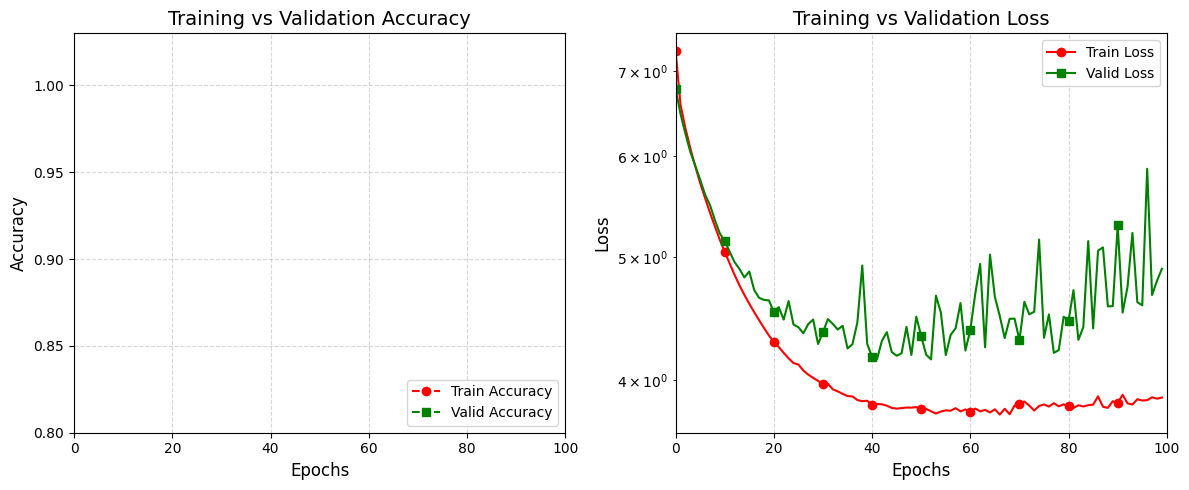

In [18]:
import matplotlib.pyplot as plt

# --- 마커 스타일 정의 ---
markers = {'train': 'o', 'valid': 's'}

# --- 전체 그림 설정 ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열

# === [1] 정확도 시각화 (왼쪽) ===
ax = axs[0]  # 왼쪽 subplot
ax.plot(
    train_acc_per_epoch_list,
    'r--',
    marker=markers['train'],
    label='Train Accuracy',
    markevery=10
)
ax.plot(
    valid_acc_per_epoch_list,
    'g--',
    marker=markers['valid'],
    label='Valid Accuracy',
    markevery=10
)

ax.set_title("Training vs Validation Accuracy", fontsize=14)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_ylim(0.8, 1.03)
ax.set_xlim(0, max_epochs)
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.5)

# === [2] 손실 시각화 (오른쪽) ===
ax = axs[1]  # 오른쪽 subplot
ax.plot(
    train_loss_per_epoch_list,
    'r-',
    marker=markers['train'],
    label='Train Loss',
    markevery=10
)
ax.plot(
    valid_loss_per_epoch_list,
    'g-',
    marker=markers['valid'],
    label='Valid Loss',
    markevery=10
)

ax.set_title("Training vs Validation Loss", fontsize=14)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.set_xlim(0, max_epochs)
ax.set_yscale('log')  # 로그 스케일 사용
ax.legend(loc='upper right')
ax.grid(True, linestyle='--', alpha=0.5)

# --- 레이아웃 정리 및 출력 ---
plt.tight_layout()
plt.show()


## 로그 파라미터 저장

In [19]:
#로그, 파라미터 저장
save_logs_npy(log_path, {
    'train_loss': train_loss_per_epoch_list,
    'train_acc': train_acc_per_epoch_list,
    'valid_loss': valid_loss_per_epoch_list,
    'valid_acc': valid_acc_per_epoch_list
})


save_dir = "logs/mapping_test"   # 원하는 폴더
os.makedirs(save_dir, exist_ok=True)

# network.params는 {'W1': ..., 'b1': ..., 'W2': ..., ...} 형태
np.savez(os.path.join(save_dir, "model_params.npz"), **network.params)

print("✅ 모델 파라미터 저장 완료")

✅ 모델 파라미터 저장 완료


## 모델 평가

In [20]:
# --- 테스트 손실 및 정확도 초기화 ---
test_loss = 0
test_acc = 0

# --- 테스트 인덱스 순회 ---
for ibatch in range(0, num_test, batch_size):
    _ibatch = ibatch + batch_size
    if _ibatch > num_test:
        _ibatch = num_test  # 범위 초과 방지

    batch_mask = idx_test[ibatch:_ibatch]
    x_batch = x_test[batch_mask]
    t_batch = t_test_fine[batch_mask]  # fine label 기준

    # 모델 예측 결과 평가
    _test_loss = network.loss(x_batch, t_batch)
    _test_acc = network.accuracy(x_batch, t_batch)

    test_loss += _test_loss
    test_acc += _test_acc

    test_loss_list.append(_test_loss)
    test_acc_list.append(_test_acc)

# --- 평균 손실 및 정확도 계산 ---
test_loss_per_epoch_list.append(test_loss / test_per_epoch)
test_acc_per_epoch_list.append(test_acc / test_per_epoch)

# --- 결과 출력 ---
print(f"[Test] loss: {test_loss_per_epoch_list[-1]:.4f}, acc: {test_acc_per_epoch_list[-1]:.4f}")


[Test] loss: 4.8870, acc: 0.1151


## 매핑 전단계.(test데이터셋에 대해서 매핑 후 성능 검사)

In [26]:
# 검증 데이터셋을 이용한 예측
y_test = network.predict(x_test)  # 아직 softmax 통과 전, logit 상태
print("예측 결과 (logit)의 shape:", y_test.shape)  # 예: (batch_size, num_classes)
print("입력 데이터(x_test)의 shape:", x_test.shape)

# softmax를 적용해 확률 분포로 변환
y_test_soft = softmax(y_test)  # 각 클래스에 대한 확률 출력

softmax_output=y_test_soft
# 예시로 첫 샘플의 예측 결과 출력
#print("첫 번째 샘플의 softmax 결과 (확률 분포):", softmax_output[0])
#print("예측된 클래스 (argmax):", np.argmax(softmax_output[0]))

# fine label 예측 결과
y_fine = np.argmax(y_test_soft, axis=1)
# fine accuracy 계산
y_fine_acc= np.mean(y_fine == t_test_fine)

print(f"Fine-class Accuracy: {y_fine_acc:.4f}")


예측 결과 (logit)의 shape: (10000, 100)
입력 데이터(x_test)의 shape: (10000, 3, 32, 32)
Fine-class Accuracy: 0.1151


## 1.단순 딕셔너리

In [22]:
import pickle

def load_fine_to_coarse_from_train(data_dir='./cifar-100-python'):
    with open(f"{data_dir}/train", 'rb') as f:
        train_data = pickle.load(f, encoding='bytes')

    fine_labels = train_data[b'fine_labels']
    coarse_labels = train_data[b'coarse_labels']

    fine_to_coarse = {}
    for f, c in zip(fine_labels, coarse_labels):
        if f not in fine_to_coarse:
            fine_to_coarse[f] = c
        else:
            assert fine_to_coarse[f] == c, f"Conflict: {f} → {fine_to_coarse[f]} vs {c}"
    
    return fine_to_coarse

In [29]:
# 매핑 테이블
def get_cifar100_fine_to_coarse_dict():
    """
    CIFAR-100의 fine label (0~99)을 coarse label (0~19)로 매핑하는 딕셔너리를 반환
    """
    fine_to_coarse = {
     0:  4,  1:  1,  2: 14,  3:  8,  4:  0,
     5:  6,  6:  7,  7:  7,  8: 18,  9:  3,
    10:  3, 11: 14, 12:  9, 13: 18, 14:  7,
    15: 11, 16:  3, 17:  9, 18:  7, 19: 11,
    20:  6, 21: 11, 22:  5, 23: 10, 24:  7,
    25:  6, 26: 13, 27: 15, 28:  3, 29: 15,
    30:  0, 31: 11, 32:  1, 33: 10, 34: 12,
    35: 14, 36: 16, 37:  9, 38: 11, 39:  5,
    40:  5, 41: 19, 42:  8, 43:  8, 44: 15,
    45: 13, 46: 14, 47: 17, 48: 18, 49: 10,
    50: 16, 51:  4, 52: 17, 53:  4, 54:  2,
    55:  0, 56: 17, 57:  4, 58: 18, 59: 17,
    60: 10, 61:  3, 62:  2, 63: 12, 64: 12,
    65: 16, 66: 12, 67:  1, 68:  9, 69: 19,
    70:  2, 71: 10, 72:  0, 73:  1, 74: 16,
    75: 12, 76:  9, 77: 13, 78: 15, 79: 13,
    80: 16, 81: 19, 82:  2, 83:  4, 84:  6,
    85: 19, 86:  5, 87:  5, 88:  8, 89: 19,
    90: 18, 91:  1, 92:  2, 93: 15, 94:  6,
    95:  0, 96: 17, 97:  8, 98: 14, 99: 13
}
    return fine_to_coarse


In [24]:
def map_softmax_to_coarse(softmax_output, fine_to_coarse):
    """
    softmax_output: shape (N, 100), softmax 확률 결과
    fine_to_coarse: dict, fine label → coarse label 매핑
    
    return: pred_coarse: shape (N,), coarse label 예측 결과
    """
    fine_pred = np.argmax(softmax_output, axis=1)  # shape (N,)
    coarse_pred = np.array([fine_to_coarse[f] for f in fine_pred])  # shape (N,)
    return coarse_pred

In [27]:
print("Softmax_output.shape",softmax_output.shape)

Softmax_output.shape (10000, 100)


In [63]:
# 매핑 딕셔너리 불러오기
fine_to_coarse = get_cifar100_fine_to_coarse_dict()

# fine label 예측 → coarse label 매핑
y_fine = np.argmax(softmax_output, axis=1)
y_coarse_dic = np.array([fine_to_coarse[f] for f in y_fine]) #이게 필요한건가?

# --- 예시 출력 ---
for a in range(30):
    print(f"[{a}] predict fine label:   {y_fine[a]}")
    print(f"    true fine label:      {t_test_fine[a]}")
    print(f"    predict coarse label: {y_coarse_dic[a]}")
    print(f"    true coarse label:    {t_test_coarse[a]}\n")


[0] predict fine label:   29
    true fine label:      49
    predict coarse label: 15
    true coarse label:    10

[1] predict fine label:   79
    true fine label:      33
    predict coarse label: 13
    true coarse label:    10

[2] predict fine label:   6
    true fine label:      72
    predict coarse label: 7
    true coarse label:    0

[3] predict fine label:   18
    true fine label:      51
    predict coarse label: 7
    true coarse label:    4

[4] predict fine label:   1
    true fine label:      71
    predict coarse label: 1
    true coarse label:    10

[5] predict fine label:   24
    true fine label:      92
    predict coarse label: 7
    true coarse label:    2

[6] predict fine label:   79
    true fine label:      15
    predict coarse label: 13
    true coarse label:    11

[7] predict fine label:   7
    true fine label:      14
    predict coarse label: 7
    true coarse label:    7

[8] predict fine label:   71
    true fine label:      23
    predict coarse

for i in range(10):
    fine = t_test_fine[i]
    coarse = t_test_coarse[i]
    mapped = fine_to_coarse[fine]
    print(f"[{i}] fine: {fine}, true coarse: {coarse}, mapped coarse: {mapped}")

## 2.confidence 기반 매핑

In [40]:
import numpy as np

def entropy_based_coarse(softmax_output, fine_to_coarse, num_coarse=20):
    """
    softmax 결과의 엔트로피를 기반으로 신뢰도를 추정하고,
    coarse-class 확률로 변환하는 후처리 함수입니다.

    Parameters:
    -----------
    softmax_output : np.ndarray
        shape (N, 100) — 모델의 fine-class softmax 출력
    fine_to_coarse : dict
        fine-class index (0~99) → coarse-class index (0~19) 매핑 딕셔너리
    num_coarse : int
        coarse 클래스 개수 (기본: 20)

    Returns:
    --------
    coarse_probs : np.ndarray
        shape (N, 20) — 각 sample의 coarse-class 확률 분포
    """

    N = softmax_output.shape[0]  # sample 개수
    log100 = np.log(100)         # 최대 엔트로피 값 (정규화용)
    coarse_probs = np.zeros((N, num_coarse))  # 결과 coarse 확률 초기화

    for i in range(N):
        # ① 해당 샘플의 softmax 벡터 (fine-class 확률)
        fine_probs = softmax_output[i]  # shape (100,)

        # ② entropy 계산 (불확실성 측정)
        entropy = -np.sum(fine_probs * np.log(fine_probs + 1e-9))  # log(0) 방지

        # ③ 신뢰도 계산: 확신이 높을수록 1에 가까움
        confidence = 1 - (entropy / log100)

        # ④ fine-class 확률에 confidence 곱하기 (확신도 기반 가중)
        weighted_fine_probs = fine_probs * confidence  # shape (100,)

        # ⑤ coarse-class 단위로 합산
        for fine_idx, prob in enumerate(weighted_fine_probs):
            coarse_idx = fine_to_coarse[fine_idx]
            coarse_probs[i][coarse_idx] += prob

    return coarse_probs  # shape (N, 20)


In [64]:
# coarse softmax 분포 계산
coarse_probs = entropy_based_coarse(softmax_output, fine_to_coarse)

# coarse 예측 (argmax)
y_fine = np.argmax(softmax_output, axis=1)
y_coarse = np.argmax(coarse_probs, axis=1)

# 정답 coarse label
y_coarse_confi = np.array([fine_to_coarse[f] for f in y_fine])

# --- 예시 출력 ---
for a in range(30):
    print(f"[{a}] predict fine label:   {y_fine[a]}")
    print(f"    true fine label:      {t_test_fine[a]}")
    print(f"    predict coarse label: {y_coarse_confi[a]}")
    print(f"    true coarse label:    {t_test_coarse[a]}\n")

[0] predict fine label:   29
    true fine label:      49
    predict coarse label: 15
    true coarse label:    10

[1] predict fine label:   79
    true fine label:      33
    predict coarse label: 13
    true coarse label:    10

[2] predict fine label:   6
    true fine label:      72
    predict coarse label: 7
    true coarse label:    0

[3] predict fine label:   18
    true fine label:      51
    predict coarse label: 7
    true coarse label:    4

[4] predict fine label:   1
    true fine label:      71
    predict coarse label: 1
    true coarse label:    10

[5] predict fine label:   24
    true fine label:      92
    predict coarse label: 7
    true coarse label:    2

[6] predict fine label:   79
    true fine label:      15
    predict coarse label: 13
    true coarse label:    11

[7] predict fine label:   7
    true fine label:      14
    predict coarse label: 7
    true coarse label:    7

[8] predict fine label:   71
    true fine label:      23
    predict coarse

## 3.soft label 기반 coarse 매핑

In [49]:
def softlabel_coarse_mapping(fine_probs, fine_to_coarse_dict, num_coarse=20):
    batch_size = fine_probs.shape[0]
    coarse_probs = np.zeros((batch_size, num_coarse))

    for fine_idx in range(100):
        coarse_idx = fine_to_coarse_dict[fine_idx]
        coarse_probs[:, coarse_idx] += fine_probs[:, fine_idx]
    
    return coarse_probs


In [67]:
#이게 뭘 하는거지
fine_to_coarse_arr = np.array([fine_to_coarse[i] for i in range(100)])

# soft-label coarse 분포 계산
coarse_probs_softlabel = softlabel_coarse_mapping(softmax_output, fine_to_coarse_arr)

y_fine = np.argmax(softmax_output, axis=1)

# coarse 예측
y_coarse_softlabel = np.argmax(coarse_probs_softlabel, axis=1)
#true_coarse = np.array([fine_to_coarse[f] for f in valid_fine])

# --- 예시 출력 ---
for a in range(30):
    print(f"[{a}] predict fine label:   {y_fine[a]}")
    print(f"     true fine label:      {t_test_fine[a]}")
    print(f"     predict coarse label: {y_coarse_softlabel[a]}")
    print(f"     true coarse label:    {t_test_coarse[a]}\n")

[0] predict fine label:   29
     true fine label:      49
     predict coarse label: 7
     true coarse label:    10

[1] predict fine label:   79
     true fine label:      33
     predict coarse label: 7
     true coarse label:    10

[2] predict fine label:   6
     true fine label:      72
     predict coarse label: 7
     true coarse label:    0

[3] predict fine label:   18
     true fine label:      51
     predict coarse label: 7
     true coarse label:    4

[4] predict fine label:   1
     true fine label:      71
     predict coarse label: 2
     true coarse label:    10

[5] predict fine label:   24
     true fine label:      92
     predict coarse label: 7
     true coarse label:    2

[6] predict fine label:   79
     true fine label:      15
     predict coarse label: 13
     true coarse label:    11

[7] predict fine label:   7
     true fine label:      14
     predict coarse label: 7
     true coarse label:    7

[8] predict fine label:   71
     true fine label:    

## 4. Validation-guided fine class weighting for coarse mapping

In [228]:
#Step 1. fine-class별 validation 정확도 계산 → fine_weight[100]
#Step 2. softmax_output × fine_weight → weighted_softmax
#Step 3. fine → coarse 그룹 합산 → coarse_probs_weighted
#Step 4. argmax(coarse_probs_weighted) → coarse 예측

In [58]:
def compute_fine_class_accuracy(pred_fine, true_fine, num_classes=100):
    correct = np.zeros(num_classes)
    total = np.zeros(num_classes)

    for pf, tf in zip(pred_fine, true_fine):
        total[tf] += 1
        if pf == tf:
            correct[tf] += 1

    acc = correct / (total + 1e-9)  # avoid divide by 0
    acc = acc / np.max(acc)        # normalize to [0, 1]
    return acc  # shape (100,)


In [59]:
def validation_weighted_coarse(softmax_output, fine_weight, fine_to_coarse, num_coarse=20):
    weighted_fine = softmax_output * fine_weight[np.newaxis, :]  # shape (N, 100)
    coarse_probs = np.zeros((softmax_output.shape[0], num_coarse))
    
    for f in range(100):
        c = fine_to_coarse[f]
        coarse_probs[:, c] += weighted_fine[:, f]
    
    return coarse_probs  # shape (N, 20)


In [74]:
# 1. fine accuracy 기반 weight 구하기
fine_acc_weight = compute_fine_class_accuracy(y_fine, t_test_fine)
# 2. 가중 coarse 확률 분포 만들기
coarse_probs_val_weight = validation_weighted_coarse(softmax_output, fine_acc_weight, fine_to_coarse)
# 3. 예측
y_coarse_validation = np.argmax(coarse_probs_val_weight, axis=1)

# --- 예시 출력 ---
for a in range(30):
    print(f"[{a}] predict fine label:   {y_fine[a]}")
    print(f"    true fine label:      {t_test_fine[a]}")
    print(f"    predict coarse label: {y_coarse_validation[a]}")
    print(f"    true coarse label:    {t_test_coarse[a]}\n")

[0] predict fine label:   29
    true fine label:      49
    predict coarse label: 7
    true coarse label:    10

[1] predict fine label:   79
    true fine label:      33
    predict coarse label: 7
    true coarse label:    10

[2] predict fine label:   6
    true fine label:      72
    predict coarse label: 7
    true coarse label:    0

[3] predict fine label:   18
    true fine label:      51
    predict coarse label: 7
    true coarse label:    4

[4] predict fine label:   1
    true fine label:      71
    predict coarse label: 1
    true coarse label:    10

[5] predict fine label:   24
    true fine label:      92
    predict coarse label: 7
    true coarse label:    2

[6] predict fine label:   79
    true fine label:      15
    predict coarse label: 7
    true coarse label:    11

[7] predict fine label:   7
    true fine label:      14
    predict coarse label: 7
    true coarse label:    7

[8] predict fine label:   71
    true fine label:      23
    predict coarse la

## 매핑 기법별 성능(정확도)

In [75]:
print("softmax_output.shape:", softmax_output.shape)  
print("valid_fine.shape:", y_fine.shape)          

softmax_output.shape: (10000, 100)
valid_fine.shape: (10000,)


In [95]:
#softmax_output todtjd
logits = network.predict(x_test)
y_fine= softmax(logits)
softmax_output=y_fine

# 공통 정답 coarse label
t_coarse = np.array([fine_to_coarse[f] for f in t_test_fine])



# 이거 필요한건가?
#valid_idx = np.arange(len(valid_fine))  
#softmax_valid = softmax_output[valid_idx]

# 1. Argmax 기반 coarse 예측
y_fine_argmax = np.argmax(softmax_output, axis=1)
y_coarse_argmax = np.array([fine_to_coarse[f] for f in y_fine_argmax])
acc_argmax = np.mean(y_coarse_argmax == t_test_coarse)

# 2. Entropy 기반
coarse_probs_entropy = entropy_based_coarse(softmax_output, fine_to_coarse)
y_coarse_entropy = np.argmax(coarse_probs_entropy, axis=1)
acc_entropy = np.mean(y_coarse_entropy == t_test_coarse)

# 3. Soft-label 평균
coarse_probs_softlabel = softlabel_coarse_mapping(softmax_output, fine_to_coarse_arr)
y_coarse_softlabel = np.argmax(coarse_probs_softlabel, axis=1)
acc_softlabel = np.mean(y_coarse_softlabel == t_test_coarse)

# 4. Validation accuracy 기반 coarse 예측
# 4-1 valid set으로 정확도 계산
logits_val = network.predict(x_valid)
softmax_val = softmax(logits_val)
val_fine_pred = np.argmax(softmax_val, axis=1)
fine_acc = compute_fine_class_accuracy(val_fine_pred, t_valid_fine)  # (100,)

#4-2 test set에 적용
y_probs_val_weight = validation_weighted_coarse(softmax_output, fine_acc, fine_to_coarse)
pred_coarse_val_weight = np.argmax(y_probs_val_weight, axis=1)
acc_val_weight = np.mean(pred_coarse_val_weight == t_test_coarse)


### 성능 출력
print("Coarse Accuracy 비교")
print(f"1. Argmax 기반           : {acc_argmax:.5f}")
print(f"2. Entropy-weighted      : {acc_entropy:.5f}")
print(f"3. Soft-label 평균 기반   : {acc_softlabel:.5f}")
print(f"4. Validation-weight 기반 : {acc_val_weight:.4f}")


Coarse Accuracy 비교
1. Argmax 기반           : 0.20260
2. Entropy-weighted      : 0.21590
3. Soft-label 평균 기반   : 0.21590
4. Validation-weight 기반 : 0.1780


## 매핑 기법별 성능(confusion matrix)

In [239]:
import numpy as np

def hierarchical_confusion_matrix(pred_fine, true_fine, fine_to_coarse, num_coarse=20):
    """
    fine label 예측 결과를 coarse label로 매핑해 confusion matrix 생성.

    Parameters:
        pred_fine: np.ndarray (N,) - 예측 fine label
        true_fine: np.ndarray (N,) - 정답 fine label
        fine_to_coarse: dict[int → int] - fine → coarse 매핑 딕셔너리
        num_coarse: coarse 클래스 개수 (default 20)

    Returns:
        np.ndarray (num_coarse x num_coarse) - 혼동 행렬
    """
    matrix = np.zeros((num_coarse, num_coarse), dtype=int)
    for pf, tf in zip(pred_fine, true_fine):
        pred_coarse = fine_to_coarse[pf]
        true_coarse = fine_to_coarse[tf]
        matrix[true_coarse][pred_coarse] += 1
    return matrix


In [162]:
print("Confusion Matrix - Argmax 기반 coarse 예측")
cm_argmax = hierarchical_confusion_matrix(pred_fine_argmax, valid_fine, fine_to_coarse)
print(cm_argmax)

print("\nConfusion Matrix - Entropy-weighted coarse 예측")
pred_fine_entropy = np.argmax(softmax_output, axis=1)  # entropy 방식은 fine도 동일
cm_entropy = hierarchical_confusion_matrix(pred_fine_entropy, valid_fine, fine_to_coarse)
print(cm_entropy)

print("\nConfusion Matrix - Soft-label 평균 coarse 예측")
pred_fine_softlabel = np.argmax(softmax_output, axis=1)  # soft-label도 fine은 동일
cm_softlabel = hierarchical_confusion_matrix(pred_fine_softlabel, valid_fine, fine_to_coarse)
print(cm_softlabel)


📌 Confusion Matrix - Argmax 기반 coarse 예측
[[14 35  6 42  4  3  6  9  4  4 11  5  9  0  1  7  3  1 27  3]
 [10 33  6 31  6  1  4  3  3  6  6 10  9  1  5 12  3  3 23  1]
 [ 8 30  5 43  8  2  7  6  7  4  7 18  9  0  5 10  4  2 22  3]
 [15 42  6 51  6  4  2  5  2  6  7 12  9  1  7 11  7  0 17  4]
 [13 39  6 40  6  5  5  6  3  7  7  9 10  0  5 10  5  0 22  2]
 [11 34  4 38  4  5  7  4  4  6  8 13 17  0  7  9  2  0 29  2]
 [16 37  5 38  4  4  3  5  5  9  5 11 12  1  6 11  5  3 18  3]
 [15 46  4 37  4  3  4  9  3  5  7  8 17  4  7 14  5  4 21  4]
 [13 43  4 48  4  2  2  2  5  6 13 10 14  1  3 13  3  3 29  0]
 [16 41  3 44  7  4  6  4  7  6 13  9 12  0  4  4  0  3 15  4]
 [16 30  2 39  7  6  3  5 10  8 16 10 12  1  1 10  3  3 27  4]
 [22 29  5 43  4  4  5  6  4  5 14  9 11  1  4  8  5  0 24  1]
 [11 44  4 32  7  2  5  3  5  4 11 14  8  0  4  9  1  1 26  4]
 [17 31  6 27  7  5  4 13  5 10  8 13 13  0  6 14  3  3 26  3]
 [19 49  5 43  2  1  6  5  2  9 10 10  8  0  3  7  2  3 21  1]
 [ 7 38  9 55 

## 매핑 기법별 성능(coarse Histogram)


📊 Histogram of Coarse Confidence - Entropy-weighted 방식


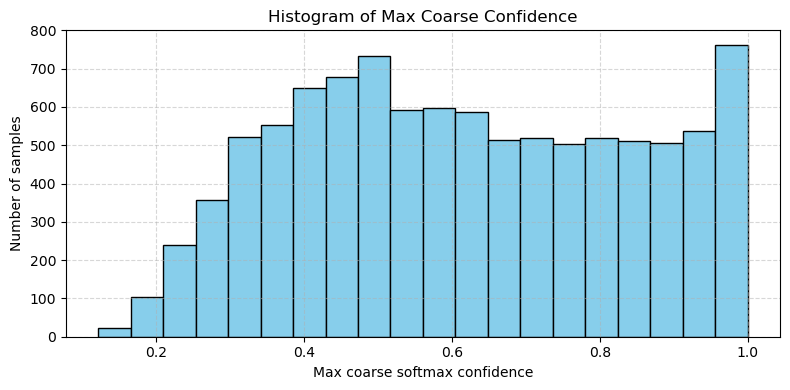


📊 Histogram of Coarse Confidence - Soft-label 평균 방식


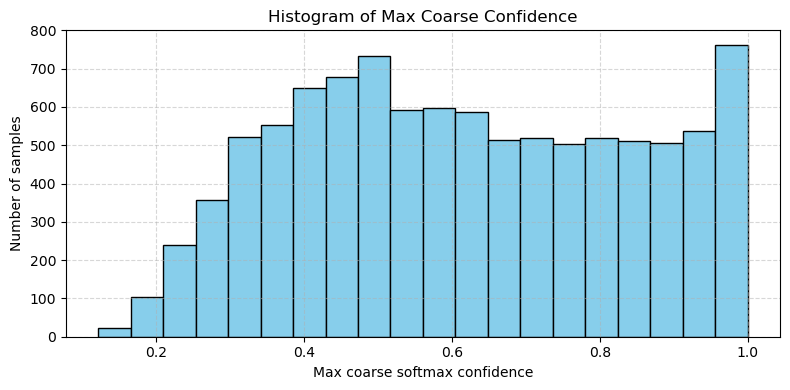